# 📊 03 - Modelagem

## 0. Configuração Inicial

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import sys
import os
sys.path.append(os.path.abspath('../models'))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
import isolation_forest

Carregando os dados de treino e teste novamente

In [2]:
x_train = pd.read_csv('../data/processed/creditcard_train.csv')
x_test = pd.read_csv('../data/processed/creditcard_test.csv')
y_test = pd.read_csv('../data/processed/creditcard_test_label.csv')

print(f"Treino carregado: {x_train.shape}")
print(f"Teste carregado: {x_test.shape}")

Treino carregado: (226602, 30)
Teste carregado: (57124, 30)


## 1. Isolation Forest

In [4]:
iso_forest, y_pred = isolation_forest.isoforest(x_train, x_test, 100, 'auto', 42, 1)


--- Relatório de Classificação ---
              precision    recall  f1-score   support

      Normal       1.00      0.96      0.98     56651
      Fraude       0.16      0.83      0.26       473

    accuracy                           0.96     57124
   macro avg       0.58      0.90      0.62     57124
weighted avg       0.99      0.96      0.97     57124



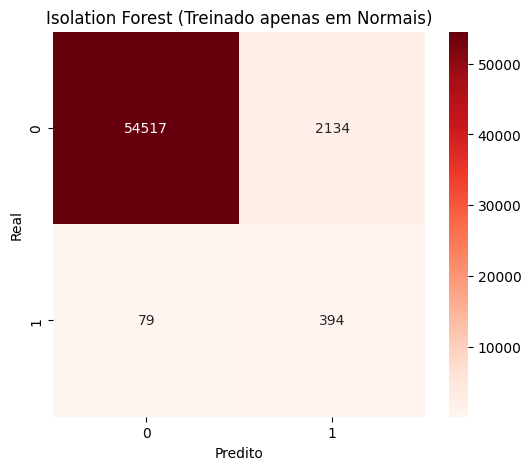

In [5]:
print("\n--- Relatório de Classificação ---")
# y_test é um DataFrame, pegamos a primeira coluna para o classification_report
print(classification_report(y_test.iloc[:, 0], y_pred, target_names=['Normal', 'Fraude']))

# Visualização da Matriz
cm = confusion_matrix(y_test.iloc[:, 0], y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title('Isolation Forest (Treinado apenas em Normais)')
plt.ylabel('Real')
plt.xlabel('Predito')
plt.show()

## 2. Local Outlier Factor (Lof)